### Auxiliary functions

Auxiliary functions
\begin{eqnarray}
\alpha_i (v; v_i, b_i, z_i) &=& r_i \exp \left[b_i z_i (v-v_i)  \right], \quad \textrm{forward rate}
\\
\beta_i (v; v_i, b_i, z_i) &=& r_i \exp \left[(b_i-1) z_i (v-v_i)  \right], \quad \textrm{backward rate}
\\
\sigma_i (v; v_i) &=& \frac{\alpha_i(v)}{\alpha_i(v)+ \beta_i(v)} = \frac{1}{1+ \exp \left[z_i (v_i-v)  \right]}, \quad \textrm{steady state} 
\\
J_U(v,w) &=& N_U r_U m_{\infty}(v) (1-w) \left[ \alpha_U(v) - \beta_U(v) \right], \quad \textrm{Up flow} 
\\
J_D(v,w) &=& N_D r_D w \left[ \alpha_D(v) - \beta_D(v) \right], \quad \textrm{Dn flow} 
\\
J_{UD}(v,w) &=& N_{UD} r_{UD} w \left[ \alpha_{UD}(v) - \beta_{UD}(v) \right], \quad \textrm{UpDn pump flow} 
\end{eqnarray}

# The Up-Dn System 

### Marco Arieli Herrera-Valdez
#### Laboratorio de Dinámica, Biofísica, y Fisiología de Sistemas, Facultad de Ciencias, UNAM
Last modified: 20230101

$\nu$ is the membrane potential

$\nu \mapsto v = \nu/\nu_T$ to simplify notation

\begin{eqnarray}
\partial_t v &=& J_F - J_{U}(v,w) - J_D(v,w) - J_{UD}(v)\\
\partial_t w &=& w^\kappa \left[ \alpha_w(v)(1-w) -  \beta_w(v) w \right]
\end{eqnarray}


In [55]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [56]:
import numpy as np
import numpy.linalg as la
from numpy.random import uniform
import matplotlib.pylab as pl
import sympy as sy
from sympy.plotting import plot, PlotGrid, plot3d
from sympy.utilities.iterables import flatten
import time
%matplotlib notebook
#%matplotlib inline


In [104]:
def delDictItem(d,key):
    r = d.copy()
    del(r[key])
    return r

def dictMerge(dict1, dict2):
    return(dict2.update(dict1))

def biasedExp(x,a,b=1):
    return sy.exp(b * (x-a))

def sigmoid(x,a,n=1):
    xn = x**n
    return xn /(xn + a**n)

def secant_method(f, x0, x1, tol=1e-5, n=0):
    n += 1 # increment counter
    y0, y1 = f(x0), f(x1) # calculate function values at endpoints
    xn = x1 - y1 * ((x1 - x0) / (y1 - y0)) # calculate next root approximation
    if -tol < y1 < tol: # check tolerance condition
        return xn, n
    # recursive call with updated interval
    return secant_method(f, x1, xn, n=n)
# ----------------------
# Numerics
# ----------------------

def RK2_autonomousStep(f, U, stepSize):
    k = stepSize * f(U) / 2
    return U + stepSize * f(U + k)

def RK2_autonomousStep2(f, U, p):
    k = p['stepSize'] * f(U,p) / 2
    return U + p['stepSize'] * f( U + k,p)


# ----------------------
# Bifurcation
# ----------------------

def fixedPoint2D_typeMarker(eigenValues,ms=5,color_nodo='orange',color_foco='blue'):
    pf=dict()
    l1,l2 = eigenValues
    r1,r2 = np.real(eigenValues)
    i1,i2 = np.imag(eigenValues)
    pf['eigVal_1'] = l1; pf['eigVal_2']=l2; pf['r1']=r1; pf['r2']=r2; pf['i1']=i1; pf['i2']=i2;
    pf['transp'] = 1; pf['mfc']= 'white'; pf['ms']= ms
    if (i1*i2<0): 
        pf['tipo']='foco';pf['mec']=color_foco;
        if r1>0: 
            pf['localDyn']='repulsor'; pf['marker']='wo'; pf['mfc'] ='white'; 
        elif r1<0:
            pf['localDyn']='attractor'; pf['marker']='ko'; pf['mfc'] =color_foco
        else:
            pf['localDyn']='centre'; pf['marker']='o'; pf['mfc']= 'gray'; pf['mec']= 'cyan'; pf['ms']=1.5*ms
    else: 
        pf['type']='nodo'; pf['mec']=color_nodo;
        if (r1*r2) < 0:
            pf['localDyn'] ='saddle'; pf['marker']='x'; pf['mfc']=color_nodo
        elif (r1*r2>0):
            if r1>0: pf['localDyn']='repulsor'; pf['marker']='o'; pf['mfc'] ='white' 
            if r1<0: pf['localDyn']='attractor'; pf['marker']='o'; pf['mfc'] =color_nodo 
        elif (r1*r2 == 0) | (r1*r2<1e-15): 
            pf['localDyn']='degen'; pf['marker']='o'; pf['mfc']= 'lightgray'; pf['mec']= 'cyan'; pf['ms']=1.5*ms
    return pf



Transformation of the slow variable for comparison with $v$
    \begin{eqnarray}
    w_{\infty} &=& \left\{ 1 + \exp \left[ g_w (v_w - v\right] \right]^{-1} \\
    v_{w\infty} &=& v_w - \frac{1}{g_w} \log \left( \frac{1}{w_{\infty}} - 1 \right)  
    \end{eqnarray}

### Up-Dn class

In [479]:
class system2D: 
    
    def __init__(self, params, variables=('x','y')):
        self.vars = variables
        self.pars = params.copy();
        self.pars_orig = params.copy()
        self.dict2symbols(params)
        self.createStateVars(variables)
        #self.defineFunctions()
        #self.updateFunctions()
        return
    
    def createStateVars(self,variables):
        print("Setting %s and %s as state variables"%(variables[0],variables[1]))
        str1 = "self.%s, self.%s = sy.symbols(%s)"%(variables[0],variables[1],variables)
        print(str1)
        return exec(str1)
    
    def resetParameters(self):
        print('Resetting dictionary to the original', self.pars_orig); self.pars = self.pars_orig.copy(); 
        return 
        
    def dict2symbols(self,di):
        for k in di.keys():
            exec("self.%s = sy.Symbol('%s')"%(k,k))
        return
    
    def nuFu_expr(self, expression, variables):
        str1 = "self.%s_ = sy.lambdify(%s, self.%s.subs(self.pars), 'numpy')"%(expression, variables, expression)
        #print(str1)
        return exec(str1)
    
    def wvTrayectory_Autonomous(self,f):
        self.timeSamples = np.arange(self.pars['timeMin'], self.pars['timeMax'], self.pars['timeStep'])
        self.nSteps = len(self.timeSamples)            
        U = np.zeros((self.nSteps, np.prod(np.shape(self.pars['ic']))),"float64")
        U[0] = self.pars['ic']
        for i in range(self.nSteps-1):
            U[i+1] = RK2_autonomousStep(f, U = U[i], stepSize = self.pars['stepSize'])
        return U.transpose()
    
    def subsJacobian(self):
        self.sysJacobian =  self.evolution.subs(self.pars).jacobian(self.vars)
        return 
        
    def eigvaluesFromFP(self,fp):
        ws,vs = fp
        self.subsJacobian()
        self.nuFu_expr(expression= 'sysJacobian', variables=self.vars)
        return la.eigvals(self.sysJacobian_(ws,vs))
    
    def parameterFromFP(self, fp, parName):
        wStar,vStar = fp; #print('Fixed point: ',fp)
        pp = self.pars.copy(); pp.pop(parName); 
        #print(self.J_inf.subs(pp).subs({'w':wStar, 'v':vStar}))
        fpEq = sy.Eq( self.ssEquation.subs(pp).subs( [(self.vars[0],wStar),(self.vars[1],vStar)], 0))
        return np.float64(sy.solve(fpEq, parName)[0])
    
    def fpType(self,eigenValues, ms=5, nodeColor='orange',focusColor='blue'):
        return fixedPoint2D_typeMarker(eigenValues, ms, nodeColor, focusColor)

    def cod1FPs(self, fps, parName, ms=5, nodeColor='blue', focusColor='gray'):
        """Inputs:
        fps ~ list of fixed points (each entry is an ordered pair, tuple, or array)
        """
        tStart = time.process_time()
        pp = dict(p); 
        pp.pop(parName)
        cod1 = list()
        nfp = len(fps)
        fps = list(); parValues = list(); evs = list(); fpTypes=list()
        for n in range(nfp): 
            parValues.append(self.parameterFromFP(fps[n],parName))
            self.pars[parName] = parValues[n]
            self.nuFu_Jacobian_subsPars()
            evs.append(self.eigvaluesFromFP(fps[n]))
            #print('(parameter, ev)=(%g,%g)'%(pv,ev))
            fpTypes.append(self.fpType(evs[n], ms, nodeColor, focusColor))
        cod1={ 'fps':fps, 'parName': parValues, 'evs':evs, 'fpTypes':fpTypes, 'nFPs':nfp}
        print('Took %d seconds to calculate the fixed point list for %s'%(time.process_time()-tStart, parName))
        return cod1
    
    def bifurcationDiagram_Cod1(self, ax, fps, coordinate, parName, nodeColor='gray', focusColor='gray', yLabel=''):
        cod1 = self.cod1FPs(fps, parName = parName, ms=3, color_nodo=nodeColor,color_foco=focusColor)
        for n in range(cod1['nFPs']):
              fpt= cod1['fpTypes'][n]
              ax.plot(cod1['parName'][n], cod1['fps'][n][coordinate],fpt['marker'], \
                    markerfacecolor=fpt['mfc'], markeredgecolor=fpt['mec'])
        ax.set_xlabel(parName); 
        ax.set_ylabel(yLabel)
        self.pars = self.pars_orig
        return cod1  
    


In [480]:
class UD(system2D):
    def __init__(self, params,variables):
        super().__init__(params,variables)
        self.defineFunctions()
        #self.updateFunctions()
        return
    
    def defineFunctions(self):
        print("Defining all functions. Notice v is normalized by v_T")
        self.e_m = biasedExp( x=self.v, a=self.v_m, b=self.g_m)
        self.e_w = biasedExp( x=self.v, a=self.v_w, b=self.g_w)
        self.e_U = biasedExp( x=self.v, a=self.v_U, b=1)
        self.e_D = biasedExp( x=self.v, a=self.v_D, b=1)
        self.e_UD = biasedExp( x=self.v, a=self.v_UD, b=1)
        self.alpha_w = self.r_w * (self.e_w ** self.b_w)
        self.beta_w = self.r_w * (self.e_w ** (self.b_w-1))
        self.alpha_U = self.r_U * (self.e_U ** self.b_U)
        self.beta_U = self.r_U * (self.e_U ** (self.b_U-1))
        self.alpha_D = self.r_D * (self.e_D ** self.b_D)
        self.beta_D = self.r_D * (self.e_D ** (self.b_D-1))
        self.alpha_UD = self.r_UD * (self.e_UD ** self.b_UD)
        self.beta_UD = self.r_UD * (self.e_UD ** (self.b_UD-1))
        self.tau_w = 1/ (self.alpha_w + self.beta_w)
        self.m_inf = self.e_m/ ( 1 + self.e_m)
        self.w_inf =  self.e_w / (1 + self.e_w)
        self.J_U = self.a_U * self.m_inf * (1-self.w) * (self.alpha_U - self.beta_U)
        self.J_D = self.a_D * self.w * (self.alpha_D - self.beta_D)
        self.J_UD = self.a_UD * (self.alpha_UD - self.beta_UD)
        self.dv = self.a_F - self.J_U - self.J_D - self.J_UD
        self.dw = self.w**self.kappa_w * (self.alpha_w - (self.alpha_w + self.beta_w)*self.w )
        self.w_vNull = (self.a_F - self.J_UD - self.a_U * self.m_inf * (self.alpha_U - self.beta_U)) \
        / (self.a_D * (self.alpha_D - self.beta_D) - self.a_U * self.m_inf * (self.alpha_U - self.beta_U))
        self.evolution = sy.Matrix([self.dw,self.dv])
        self.ssEquation = self.dv.subs({'w': self.w_inf})
        return
    
    def updateFunctions(self):
        self.nuFu_expr(expression='dw',variables=['w','v'])
        self.nuFu_expr(expression='dv',variables=['w','v'])
        self.nuFu_expr(expression='w_inf',variables=['v'])
        self.nuFu_expr(expression='w_vNull',variables=['v'])
        self.nuFu_expr(expression='J_UD',variables=['v'])
        self.nuFu_expr(expression='J_U',variables=['w','v'])
        self.nuFu_expr(expression='J_D',variables=['w','v'])
        self.nuFu_expr(expression='ssEquation',variables=['v'])
        return 
    
    def phasePlane(self, ax, W = np.arange(0,1,0.05), V = np.arange(-60,30,0.1)/v_T, wNullLabel='', vNullLabel=''):
        upDn.nuFu_expr(expression='dw',variables=['w','v'])
        upDn.nuFu_expr(expression='dv',variables=['w','v'])
        upDn.nuFu_expr(expression='w_inf',variables=['v'])
        upDn.nuFu_expr(expression='w_vNull',variables=['v'])
        Wgrid,Vgrid = np.meshgrid(W, V)
        w_wNull = upDn.w_inf_(V); w_vNull = upDn.w_vNull_(V)
        dV = upDn.dv_(Wgrid,Vgrid); dW = upDn.dw_(Wgrid,Vgrid); 
        ax.streamplot(W,V,dW,dV, color = 'gray',linewidth=1);
        ax.plot(w_vNull, V, lw=2,   color = 'green',label=vNullLabel);
        ax.plot(w_wNull, V, lw=2, color = 'blue',label=wNullLabel)
        return ax

    def dvw_(self,U):
        w,v = U
        return np.array([self.dw_(w,v),self.dv_(w,v)])

    def wvTrayectory_nonAutonomous(self, parNames=[], parVals=[]):
        '''
        parNames and parVals must be lists of the same length. 
        Each element in parVals must have the same length as the timeSample vector
        '''     
        self.timeSamples = np.arange(self.pars['timeMin'],self.timeMax,self.timeStep)
        self.nSteps = len(self.timeSamples)            
        nPars = len(parNames)
        for n in range(nPars):
            nVals = len(parVals[n])
            accert (self.nSteps != nVals), 'The number of parameter values does not coincide with the number of steps'
            
        U=np.zeros((self.nSteps, np.prod(np.shape(self.pars['ic']))),"float64")
        U[0] = self.ic
        for nn in range(self.nSteps-1):
            for n in range(nPars):
                self.pars[parNames[n]]= parVals[n][nn]
            U[i+1] = RK2_autonomousStep(f= self.dvw_, U = U[i], stepSize = self.pars['stepSize'])
        return U.transpose()            
            
    def getDynamics(self):
        self.updateFunctions()
        self.w, self.v = self.wvTrayectory_Autonomous()
        self.u = self.v * self.pars['v_T']
        self.dudt = np.zeros(len(self.u))
        self.dudt[1:] = (self.u[1:]-self.u[:-1])/upDn.pars['timeStep']
        print('Max dv/dt = %g V/s'% self.dvdt.max())
        self.I_U = self.pars['vTCm'] * self.J_U_(self.w,self.v)  
        self.I_D = self.pars['vTCm'] * self.J_D_(self.w,self.v) 
        self.I_UD = self.pars['vTCm'] * self.J_UD_(self.v)
        return 
    
    def plotDynamicProfile(self,vMax = 40, vMin = -80, iMin=-10, iMax=70): 
        f = pl.figure(figsize=(7,7)); pl.ioff(); 
        ax = list(); rows = 3; cols= 2;
        for n in range(rows*cols):
            ax.append(f.add_subplot(3,2,n+1))
        pl_tv, pl_dvv, pl_tjL, pl_dvjL, pl_tjS, pl_dvjS = ax
        #
        pl_tv.plot(self.timeSamples, self.u, label=r'$v(t)$')
        pl_tv.set_xlabel(r'time (ms)'); pl_tv.set_ylabel(r'mV')
        pl_tv.set_ylim(vMin,vMax); pl_tv.legend()
        pl_dvv.plot(self.dvdt, self.u)
        #
        pl_dvv.set_ylim(vMin,vMax);
        pl_tjS.plot(self.timeSamples, self.I_UD, label=r'$I_{UD}$')
        pl_tjL.plot(self.timeSamples, self.I_U, label=r'$I_{D}$')
        pl_tjL.plot(self.timeSamples, self.I_D, label=r'$I_{U}$')
        pl_tjS.set_xlabel(r'time (ms)'); pl_tjS.set_ylabel(r'pA'); 
        pl_tjL.set_xlabel(r'time (ms)'); pl_tjL.set_ylabel(r'pA');
        pl_tjS.set_ylim(iMin,iMax); pl_tjL.legend()
        pl_dvjS.plot(self.dvdt, self.I_UD )
        pl_dvjL.plot(self.dvdt, self.I_D )
        pl_dvjL.plot(self.dvdt, self.I_U )
        pl_dvjS.set_xlabel(r'$\partial_t v(t)$ (V/s)'); pl_dvjS.set_ylabel(r'pA')
        pl_dvjS.set_ylim(iMin,iMax);
        pl.ion(); pl.draw()
        return f
    
    


## UpDn class instance

In [481]:
eCharge=1.60217733e-19 # Coulombs; 
kBoltzmann=1.38065812e-20 #mJ/K
zeroT=273.15 #deg Kelvin
TCelcius = 36
v_T = kBoltzmann * (zeroT + TCelcius)/ eCharge
C_m = 20.0; vTCm= v_T * C_m
voltages = {'v_w':0/v_T, 'v_m': -17.0/v_T,'v_U':60.0/v_T, 'v_D':-90.0/v_T, 'v_UD':-60.0/v_T}
biases = {'b_w':0.4, 'b_U':0.5, 'b_D':0.1, 'b_UD':0.1, 'g_m':6, 'g_w':2.5}
rates = {'r_w':0.7, 'a_F': 0*100 / vTCm, 'r_U':1, 'r_D':1, 'r_UD':1e-4, 'a_U': 2, 'a_D': 12.0, 'a_UD':0.025}
numerics = {'timeMin': -1.0, 'timeMax':50.0, 'timeStep':1/40.0, 'ic': np.array([0.0001, -60.0/v_T])}
p = {'v_T': v_T, 'C_m':C_m, 'vTCm': v_T * C_m, 'kappa_w':0.3}
p= {**p, **voltages, **biases, **rates, **numerics}
upDn = UD(params= p, variables=('w','v'))
print(r'v_T=%g, C_m=%g, v_T C_m= %g'%(p['v_T'],p['C_m'], p['vTCm']))

Setting w and v as state variables
self.w, self.v = sy.symbols(('w', 'v'))
Defining all functions. Notice v is normalized by v_T
v_T=26.6407, C_m=20, v_T C_m= 532.813


## Stream vectors and the effects of activation parameters on the nullclines

The nullclines of the system are given by the curves
\begin{eqnarray}
    w_{vNull} &=& \frac{J_F - a_{UD}  \left[ \alpha_{UD}(v) - \beta_{UD}(v) \right] - a_U m_{\infty}(v) \left[ \alpha_U(v) - \beta_U(v) \right] }
    { a_{D}  \left[ \alpha_{D}(v) - \beta_{D}(v) \right] - a_U m_{\infty}(v) \left[ \alpha_U(v) - \beta_U(v) \right] }
    \\
    w_{wNull} &=& \frac{ \alpha_w(v)}{\alpha_w(v)+\beta_w(v)} = \frac{1}{1 + \exp \left[ (v_w - w) g_w\right]}
\end{eqnarray}

The system may have 1, 2 (seldom), or 3 fixed points. The system is more likely to have 3 fixed points if the slope of the $w$-nullcline is smaller than the slope of the $v$-nullcline, and both curves are very close to each other.

One important combination of parameters is the pair $(v_w, g_w)$. Larger values of $v_w$ shift the $w$-nullcline to the right, while larger values of $g_w$ bend the $w$-nullcline so that the curve is at higher points for smaller values of $v$. This means that the intersection between the $w$- and $v$-nullclines can shift toward larger $v$ values for smaller values of $g_w$, or for larger values of $v_w$. 



Resetting dictionary to the original {'v_T': 26.640650183085537, 'C_m': 20.0, 'vTCm': 532.8130036617107, 'kappa_w': 0.3, 'v_w': 0.0, 'v_m': -0.6381225639452862, 'v_U': 2.252197284512775, 'v_D': -3.378295926769162, 'v_UD': -2.252197284512775, 'b_w': 0.4, 'b_U': 0.5, 'b_D': 0.1, 'b_UD': 0.1, 'g_m': 6, 'g_w': 2.5, 'r_w': 0.7, 'a_F': 0.0, 'r_U': 1, 'r_D': 1, 'r_UD': 0.0001, 'a_U': 2, 'a_D': 12.0, 'a_UD': 0.025, 'timeMin': -1.0, 'timeMax': 50.0, 'timeStep': 0.025, 'ic': array([ 1.00000000e-04, -2.25219728e+00])}


<IPython.core.display.Javascript object>


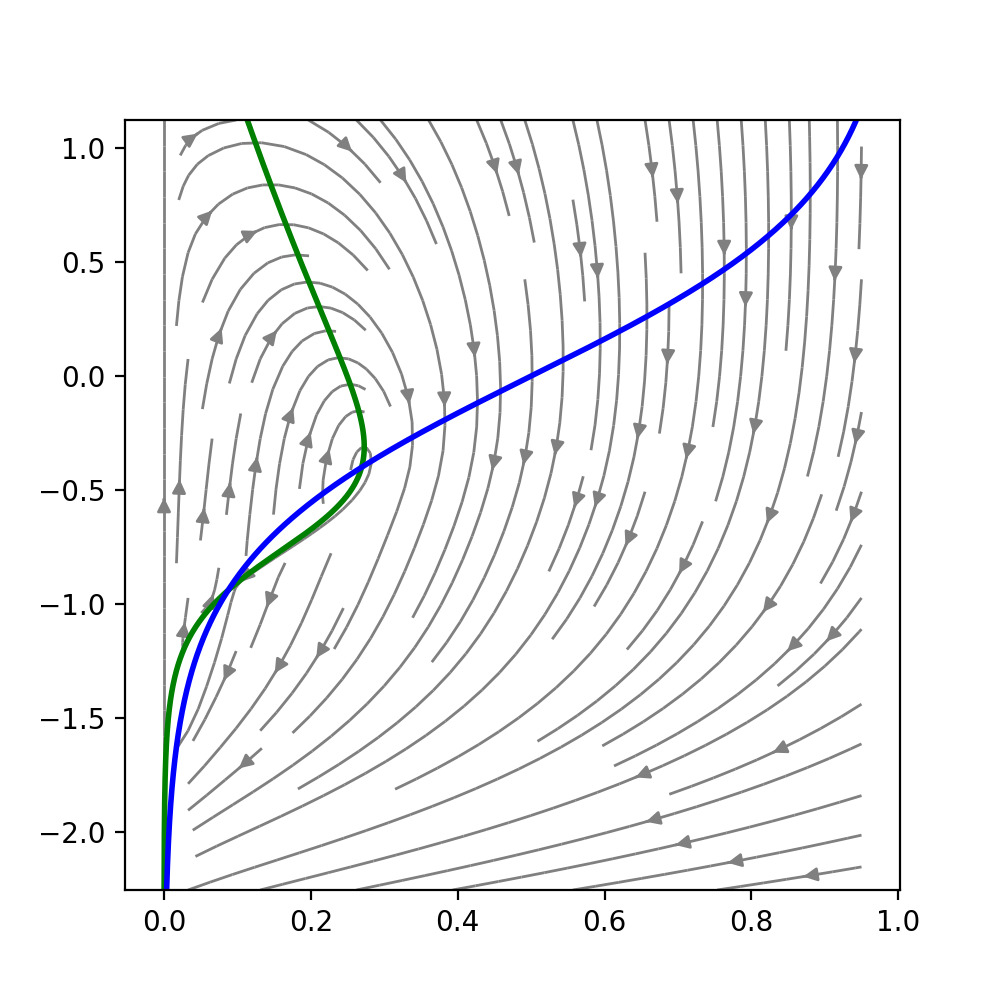

Fixed point at (0.000216243,-3.37556)


{'eigVal_1': -8.803436070351276,
 'eigVal_2': -0.0025999550169744185,
 'r1': -8.803436070351276,
 'r2': -0.0025999550169744185,
 'i1': 0.0,
 'i2': 0.0,
 'transp': 1,
 'mfc': 'orange',
 'ms': 5,
 'type': 'nodo',
 'mec': 'orange',
 'localDyn': 'attractor',
 'marker': 'o'}

In [483]:
upDn.resetParameters()
upDn.nuFu_expr(expression='ssEquation',variables=['v'])
upDn.nuFu_expr(expression='w_inf',variables=['v'])
f = pl.figure(figsize=(5,5)); ax = f.add_subplot(111)
upDn.phasePlane(ax)
v_star, n = secant_method(f = upDn.ssEquation_, x0=-2, x1=-1.5, tol=1e-3, n=0)
w_star= upDn.w_inf_(v_star)
print("Fixed point at (%g,%g)"%(w_star,v_star))
evs = upDn.eigvaluesFromFP(fp = (w_star,v_star))
upDn.fpType(evs)

<IPython.core.display.Javascript object>


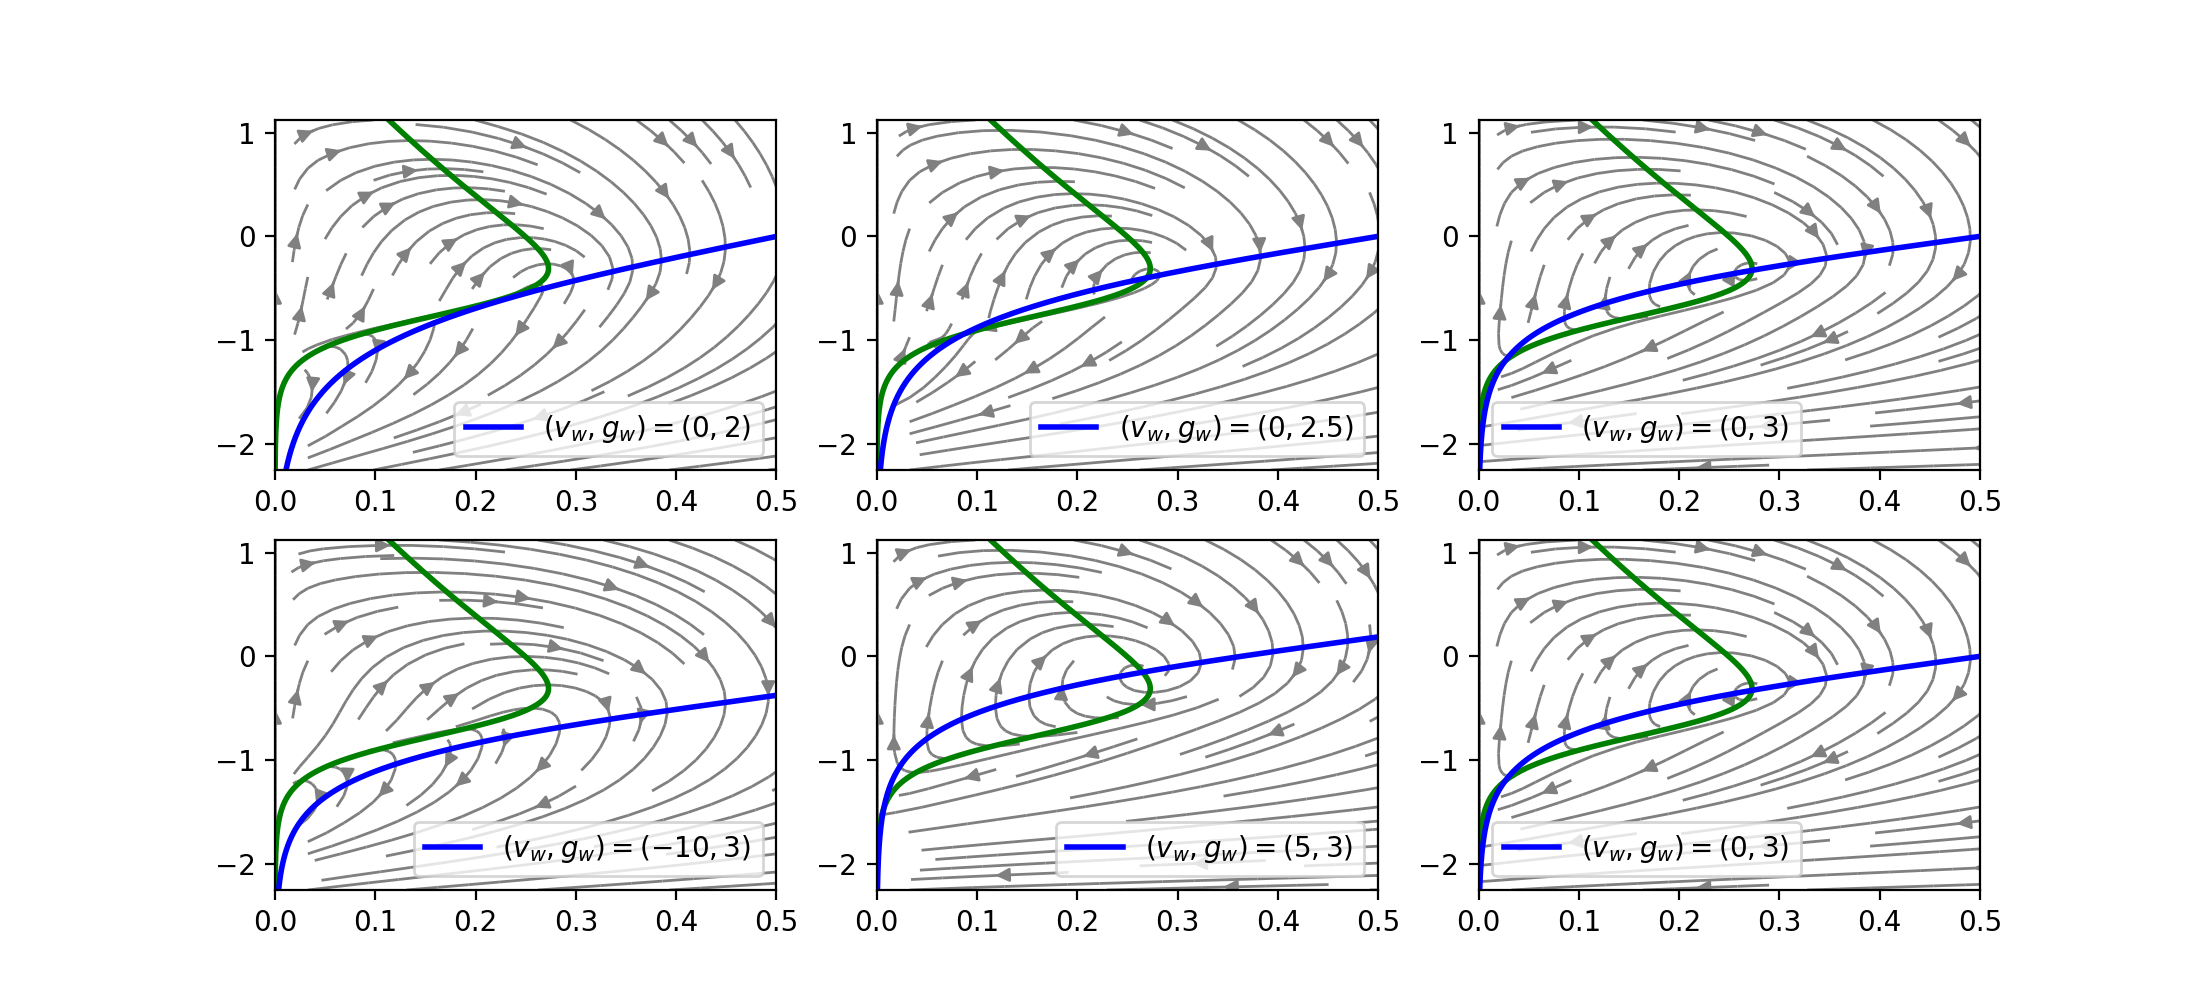

Resetting dictionary to the original {'v_T': 26.640650183085537, 'C_m': 20.0, 'vTCm': 532.8130036617107, 'kappa_w': 0.3, 'v_w': 0.0, 'v_m': -0.6381225639452862, 'v_U': 2.252197284512775, 'v_D': -3.378295926769162, 'v_UD': -2.252197284512775, 'b_w': 0.4, 'b_U': 0.5, 'b_D': 0.1, 'b_UD': 0.1, 'g_m': 6, 'g_w': 2.5, 'r_w': 0.7, 'a_F': 0.0, 'r_U': 1, 'r_D': 1, 'r_UD': 0.0001, 'a_U': 2, 'a_D': 12.0, 'a_UD': 0.025, 'timeMin': -1.0, 'timeMax': 50.0, 'timeStep': 0.025, 'ic': array([ 1.00000000e-04, -2.25219728e+00])}


In [458]:
# Variation on (v_w,g_w)
upDn.nuFu_expr(expression='dw',variables=['w','v'])
upDn.nuFu_expr(expression='dv',variables=['w','v'])
upDn.nuFu_expr(expression='w_inf',variables=['v'])
upDn.nuFu_expr(expression='w_vNull',variables=['v'])
upDn.nuFu_expr(expression='ssEquation',variables=['v'])
W = np.arange(0,1,0.05); V = np.arange(-60,30,1)/v_T
Wgrid,Vgrid = np.meshgrid(W, V)
dV = upDn.dv_(Wgrid,Vgrid); 
w_wNull = upDn.w_inf_(V); w_vNull = upDn.w_vNull_(V)
#
fig = pl.figure(figsize=(11,5)); #pl.ioff()
ax = list(); bx = list()
gws = [2, 2.5, 3]; vws = np.array([-10,5,0])/v_T
ngs = len(gws); 

for n in range(ngs):
    ax.append(fig.add_subplot(2,ngs,n+1))
    bx.append(fig.add_subplot(2,ngs, ngs + n+1))
    
for n in range(ngs):
    upDn.pars['g_w']= gws[n]; 
    wNullLabel = r'$(v_w,g_w)=(%g,%g)$'%(upDn.pars['v_w']*v_T,upDn.pars['g_w'])
    upDn.phasePlane(ax[n], wNullLabel=wNullLabel)
    ax[n].set_xlim(0,0.5)
    ax[n].legend()
    
for n in range(ngs):
    upDn.pars['v_w']= vws[n]; 
    wNullLabel = r'$(v_w,g_w)=(%g,%g)$'%(upDn.pars['v_w']*v_T,upDn.pars['g_w'])
    upDn.phasePlane(bx[n], wNullLabel=wNullLabel)
    bx[n].set_xlim(0,0.5)
    bx[n].legend()
    
upDn.resetParameters()


Resetting dictionary to the original {'v_T': 26.640650183085537, 'C_m': 20.0, 'vTCm': 532.8130036617107, 'kappa_w': 0.3, 'v_w': 0.0, 'v_m': -0.6381225639452862, 'v_U': 2.252197284512775, 'v_D': -3.378295926769162, 'v_UD': -2.252197284512775, 'b_w': 0.4, 'b_U': 0.5, 'b_D': 0.1, 'b_UD': 0.1, 'g_m': 6, 'g_w': 2.5, 'r_w': 0.7, 'a_F': 0.0, 'r_U': 1, 'r_D': 1, 'r_UD': 0.0001, 'a_U': 2, 'a_D': 12.0, 'a_UD': 0.025, 'timeMin': -1.0, 'timeMax': 50.0, 'timeStep': 0.025, 'ic': array([ 1.00000000e-04, -2.25219728e+00])}


<IPython.core.display.Javascript object>


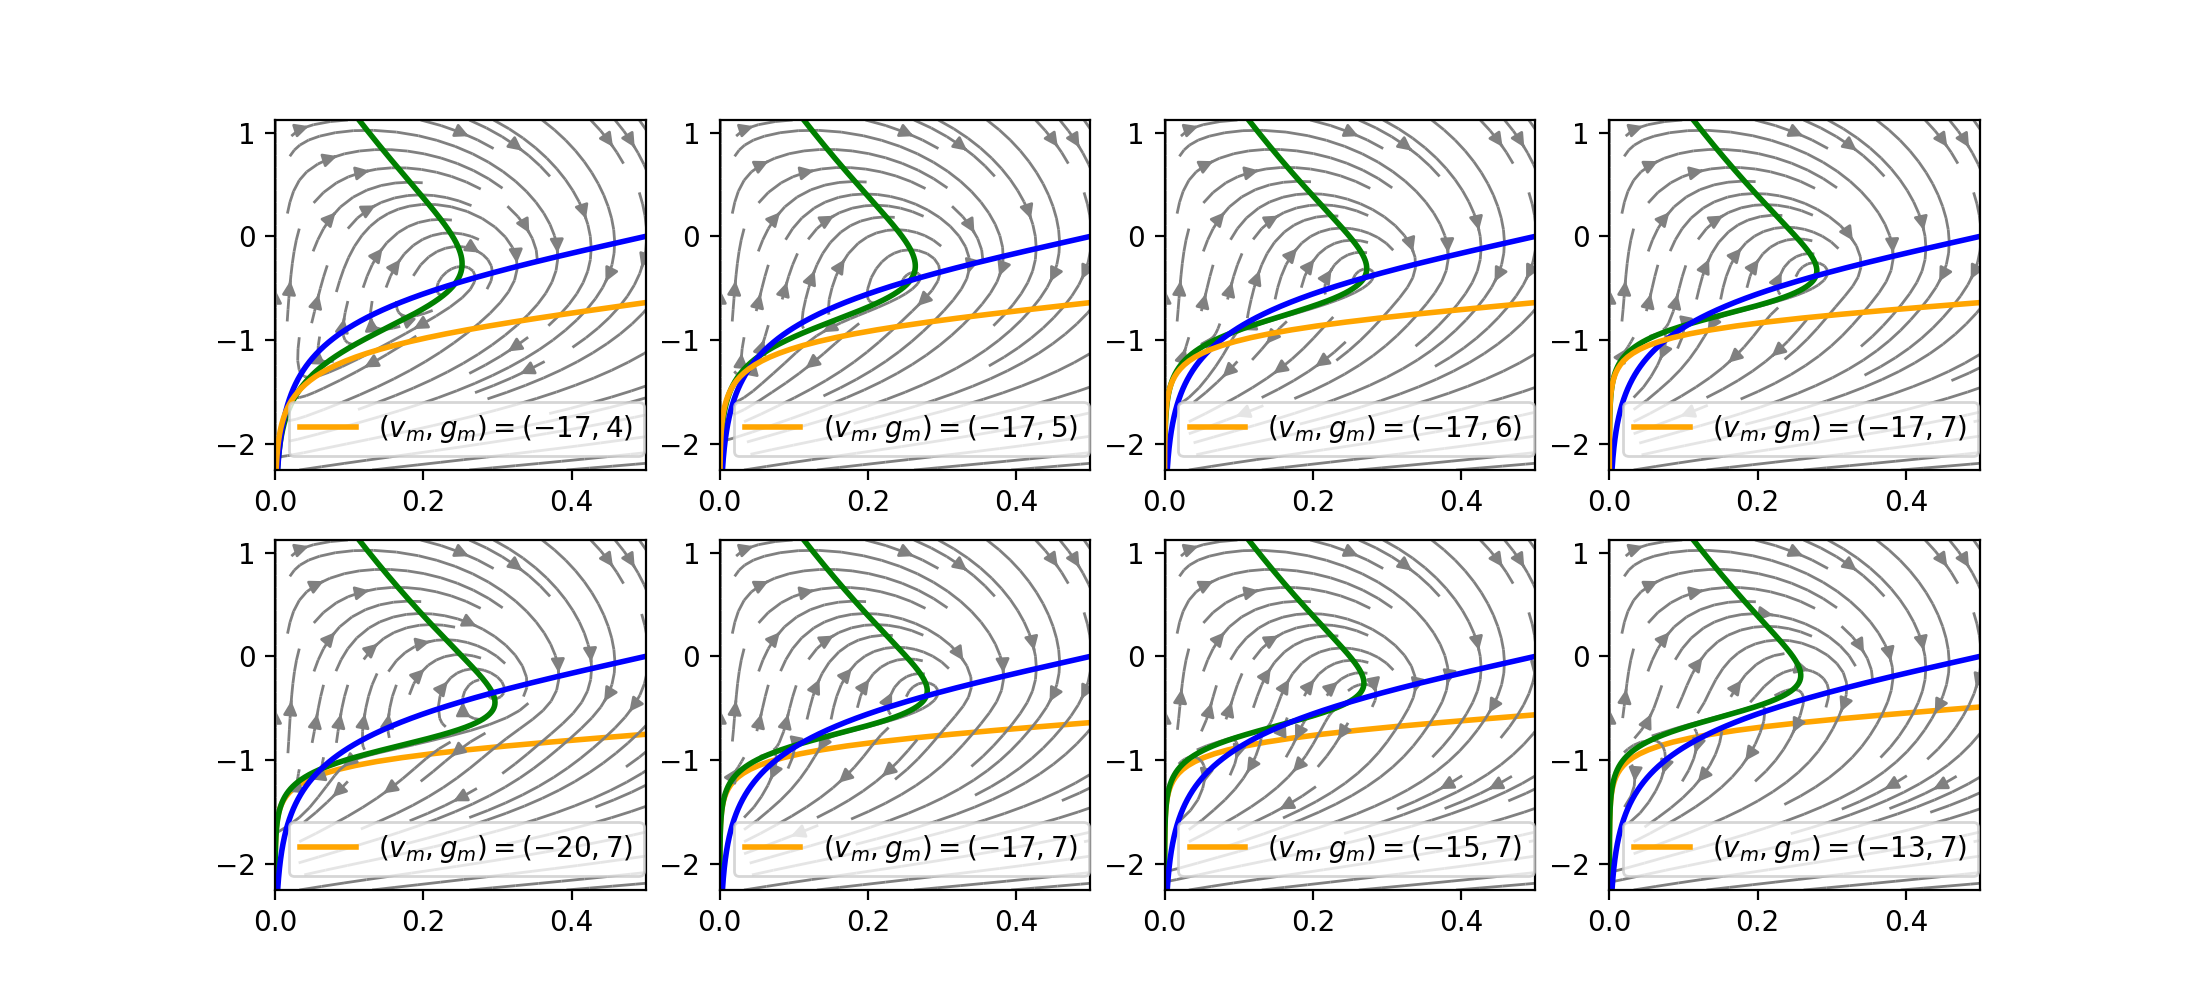

In [452]:
# Variation on (v_m,g_m)
upDn.resetParameters();
upDn.nuFu_expr(expression='dw',variables=['w','v'])
upDn.nuFu_expr(expression='dv',variables=['w','v'])
upDn.nuFu_expr(expression='m_inf',variables=['v'])
upDn.nuFu_expr(expression='w_inf',variables=['v'])
upDn.nuFu_expr(expression='w_vNull',variables=['v'])
upDn.nuFu_expr(expression='ssEquation',variables=['v'])
W = np.arange(0,1,0.05); V = np.arange(-60,30,1)/v_T
Wgrid,Vgrid = np.meshgrid(W, V)
dV = upDn.dv_(Wgrid,Vgrid); dW = upDn.dw_(Wgrid,Vgrid); 
w_wNull = upDn.w_inf_(V); w_vNull = upDn.w_vNull_(V)
#
fig = pl.figure(figsize=(11,5)); #pl.ioff()
ax = list(); bx = list()
gms = [4, 5, 6, 7]; vms = np.array([-20,-17,-15,-13])/v_T
ngs = len(gms); 
for n in range(ngs):
    ax.append(fig.add_subplot(2,ngs,n+1))
    bx.append(fig.add_subplot(2,ngs, ngs + n+1))
    
for n in range(ngs):
    upDn.pars['g_m']= gms[n]; 
    strLabel = r'$(v_m,g_m)=(%g,%g)$'%(upDn.pars['v_m']*v_T, upDn.pars['g_m'])
    upDn.nuFu_expr(expression='m_inf',variables=['v'])
    upDn.nuFu_expr(expression='w_vNull',variables=['v'])
    w_vNull = upDn.w_vNull_(V); mInf = upDn.m_inf_(V)
    upDn.phasePlane(ax[n])
    ax[n].plot(mInf, V, lw=2,   color = 'orange',  label=strLabel);
    ax[n].set_xlim(0,0.5)
    ax[n].legend()
    
for n in range(ngs):
    upDn.pars['v_m']= vms[n]; 
    strLabel = r'$(v_m,g_m)=(%g,%g)$'%(upDn.pars['v_m']*v_T, upDn.pars['g_m'])
    upDn.nuFu_expr(expression='m_inf',variables=['v'])
    upDn.nuFu_expr(expression='w_vNull',variables=['v'])
    w_vNull = upDn.w_vNull_(V); mInf = upDn.m_inf_(V)
    bx[n].plot(mInf, V, lw=2,   color = 'orange', label=strLabel);
    upDn.phasePlane(bx[n])
    bx[n].set_xlim(0,0.5)
    bx[n].legend()



### Channel gating: Activation, deactivation, and time constant functions


### Characteristic rates

<lambdifygenerated-184>:2: RuntimeWarning: divide by zero encountered in power
  return array([[0.3*w**(-0.7)*(-w*(0.896790282849657*exp(2.2*v)**(-0.6) + 0.593429963296182*exp(2.2*v)**0.4) + 0.593429963296182*exp(2.2*v)**0.4) + w**0.3*(-0.896790282849657*exp(2.2*v)**(-0.6) - 0.593429963296182*exp(2.2*v)**0.4), w**0.3*(-w*(-1.18376317336155*exp(2.2*v)**(-0.6) + 0.52221836770064*exp(2.2*v)**0.4) + 0.52221836770064*exp(2.2*v)**0.4)], [33.3945858385568*(-3.08360276492172*exp(v)**(-0.5) + 0.324295986297504*sqrt(exp(v)))*exp(5*v)/(16.6972929192784*exp(5*v) + 1) + 0.573751051858639*exp(v)**(-0.9) - 16.8228190650304*exp(v)**0.1, -12.0*w*(0.0430313288893979*exp(v)**(-0.9) + 0.140190158875253*exp(v)**0.1) - 166.972929192784*(1 - w)*(-3.08360276492172*exp(v)**(-0.5) + 0.324295986297504*sqrt(exp(v)))*exp(5*v)/(16.6972929192784*exp(5*v) + 1) + 10.0*(1 - w)*(-3.08360276492172*exp(v)**(-0.5) + 0.324295986297504*sqrt(exp(v)))*exp(10*v)/(exp(5*v) + 0.0598899477199335)**2 - 33.3945858385568*(1 - w)*(1.5

<IPython.core.display.Javascript object>


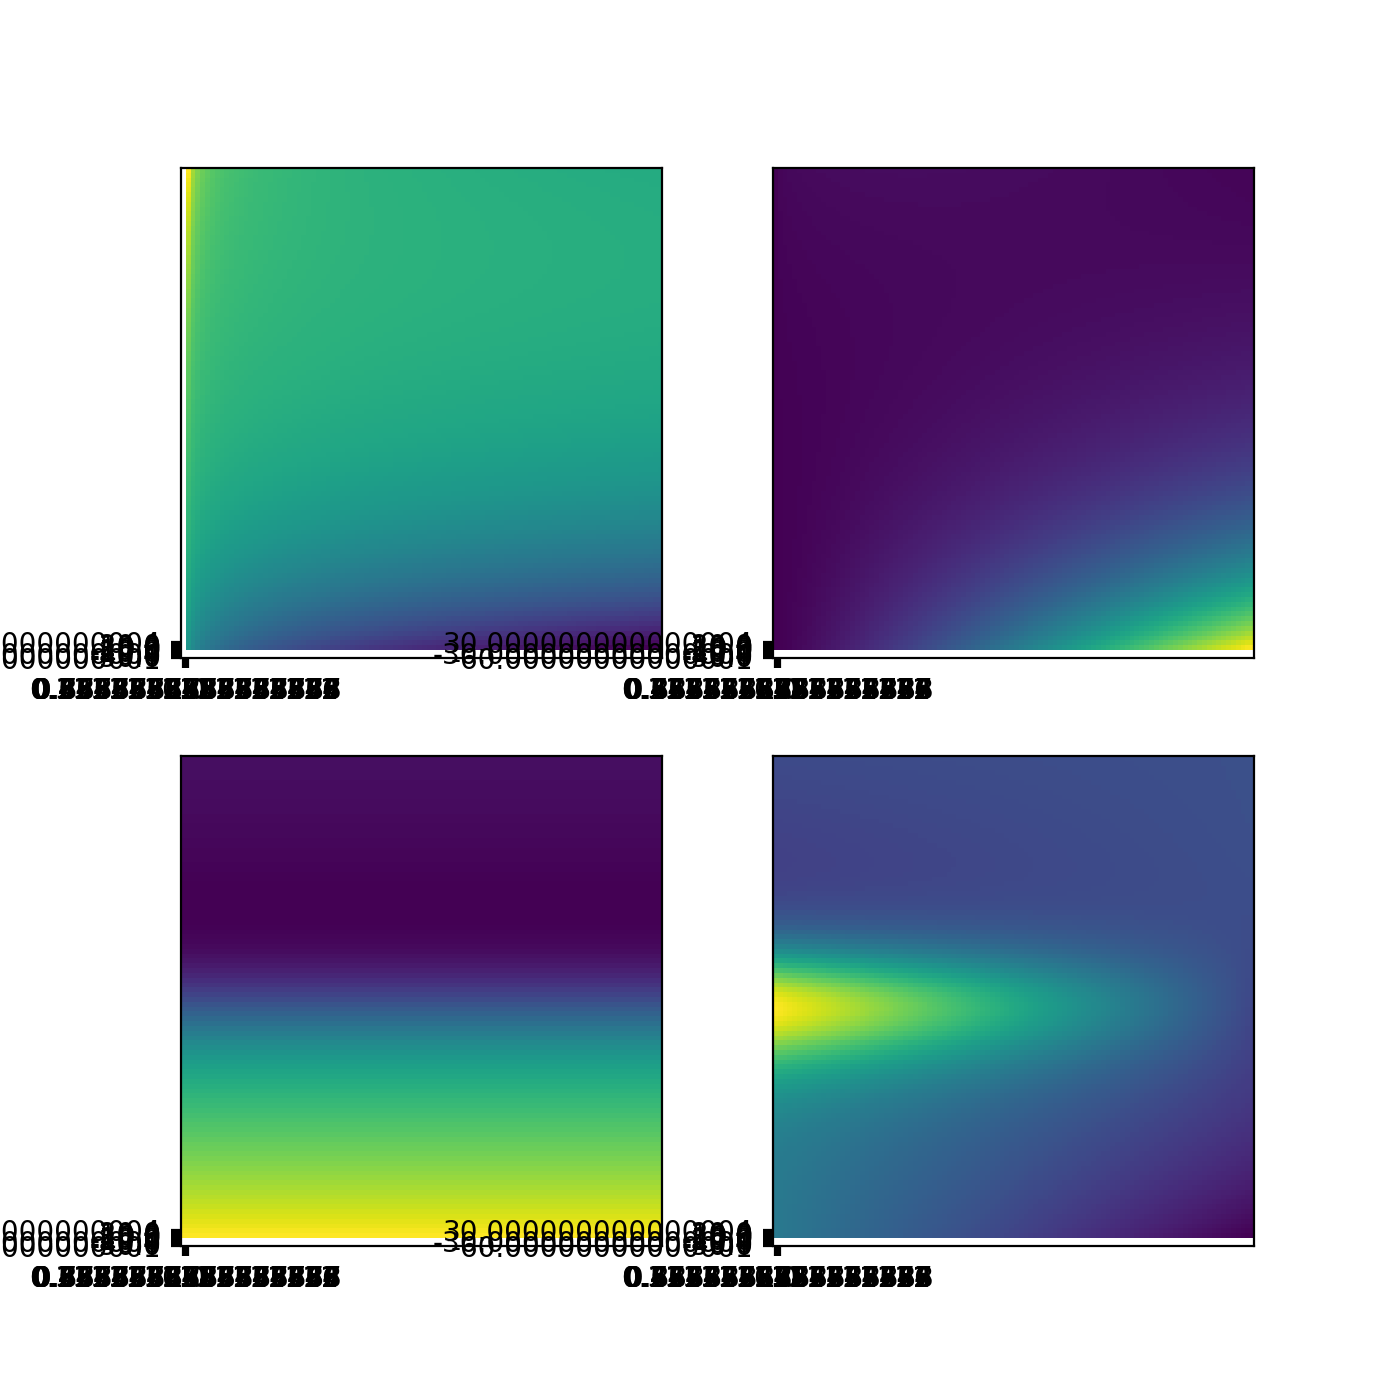

In [107]:
upDn.nuFu_Jacobian_subsPars()
#Ws = uniform(0,1,256); Vs = uniform(-60,30,256)/v_T
vMin = -60; vMax=30; wMin=0; wMax=1
vRange = np.linspace(vMin,vMax,100)/v_T; wRange=np.linspace(wMin,wMax,100)
Ws,Vs = np.meshgrid(wRange,vRange)
J = upDn.Jacobian_(Ws,Vs)
rows = 2; cols=2

fig = pl.figure(figsize=(7,7)); ax = list(); 
wTicks = np.linspace(wMin,wMax,10)
vTicks = np.linspace(vMin,vMax,10)/v_T
for i in [0,1]:
    for j in [0,1]:
        ij = i* rows + j 
        ax.append(fig.add_subplot(rows,cols, ij +1))
        z = J[i,j]
        ax[ij].imshow(z, origin='lower')
        ax[ij].set_xticks(ticks= wTicks, labels = wTicks)
        ax[ij].set_yticks(ticks= vTicks, labels = vTicks*v_T)

pl.show()        


## Dynamics

In [ ]:
upDn = UD(p)
upDn.pars['v_m']= -20.0/v_T; upDn.pars['g_m']= 5;  upDn.pars['b_w'] = 0.4
upDn.pars['v_w']= -10.0/v_T; upDn.pars['g_w']= 3.2;  upDn.pars['r_w'] = 0.7
upDn.pars['a_F'] = 99 / vTCm
upDn.pars['a_U'] = 4.; upDn.pars['a_D'] = 6.125; upDn.pars['a_UD'] = 0.08;
upDn.pars['timeMax'] = 500.0; upDn.pars['ic'][1] = -60.0/v_T
#
if (upDn.pars['a_UD']>0):  print('tau_m = %g ms'%(1/upDn.pars['a_UD']))
upDn.getDynamics()
upDn.dynamicProfile()

### Steady state currents and K-current rectification


### Steady state flows  ($I_{\infty}$)

### Bifurcation structures
#### Characteristic time constants
#### Bifurcations in codimension 1

In [ ]:
upDn = UD(p)
fp = np.array([0.001,2])
upDn.eigvaluesFromFP(fp)

In [ ]:
f=pl.figure(figsize=(9,4)); pl.ioff()
ax = f.add_subplot(111)
fpList= upDn.bifurcationDiagram_Cod1(ax, parName='a_F', nodeColor='gray', focusColor='blue')
pl.ion(); pl.draw();pl.show()

#### Multiple bifurcation diagrams

In [ ]:
upDn = UD(p)
parNames = ['a_F','a_UD','a_U','a_D']
xMin=[-5,0,0,0]
xMax=[20,40,50,50]
nPars = len(parNames);
nCols = 2
nRows = np.int32(np.ceil(nPars/nCols))
f=pl.figure(figsize=(9,7)); ax = list()
fpLists = list()
for n in range(nPars):
    ax.append(f.add_subplot(nRows,nCols,n+1));pl.ioff(); 
    fpLists.append(upDn.bifurcationDiagram_Cod1(ax[n], parName=parNames[n], nodeColor='gray', focusColor='blue'))
    #ax[n].set_xlim(xMin[n],fpLists[n][parName].max())
    pl.ion(); pl.draw();
pl.show()


In [ ]:
class SymbolicModel():
  def __init__():
    pass

class NumericModel()
  def __init__():
    pass

class UDFamily(SymbolicModel,NumericModel):
  def __init__():
    pass

class UD(UDFamily):
  def __init__():
    pass

class ComkComs():
  def __init__():
    pass